<a href="https://colab.research.google.com/github/ShyrleyFlor/Fresas_PDI_/blob/main/PDI_fresas_Segmentaci%C3%B3n_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import cv2  # Asegúrate de importar cv2 en lugar de importar funciones individuales
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import gdown

In [56]:
# Descargar la imagen desde Google Drive
file_id = '1HtFNH1PFCLCS3UJXMrOjogV7XGvSA45U'
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', 'fresas.jpg', quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1HtFNH1PFCLCS3UJXMrOjogV7XGvSA45U
To: /content/fresas.jpg
100%|██████████| 12.7k/12.7k [00:00<00:00, 21.6MB/s]


'fresas.jpg'

In [57]:
def howis(img):
    print('size = ', img.shape)
    print('max  = ', np.max(img))
    print('min  = ', np.min(img))

def mostrar_imagen_y_dimensiones(img, title="Imagen"):
    cv2_imshow(img)
    print(title)
    howis(img)


In [58]:
def descomponer_canales_rgb(img):
    # Convertir de BGR a RGB
    img_rgb = img[:, :, [2, 1, 0]]
    R = img_rgb[:, :, 0]
    G = img_rgb[:, :, 1]
    B = img_rgb[:, :, 2]
    return R, G, B, img_rgb

def segmentar_fresa(img, thresholds):
    R, G, B, img_rgb = descomponer_canales_rgb(img)

    # Umbrales para segmentar una fresa
    Sr = R > thresholds['R']
    Sg = G < thresholds['G']
    Sb = B < thresholds['B']

    Srg = np.logical_and(Sr, Sg)
    S = np.logical_and(Srg, Sb)

    # Filtrado de filas con menos de 20 píxeles segmentados
    (N, M) = S.shape
    Q = S.copy()
    for i in range(N):
        s = np.sum(S[i, :])
        if s < 20:
            Q[i, :] = 0

    return Q, img_rgb


In [59]:
def detectar_bordes(Q):
    # Detección de bordes utilizando el algoritmo de Canny
    E = cv2.Canny(Q.astype(np.uint8) * 255, 100, 200)
    return E

def encontrar_contornos_segmentados(Q):
    # Encontrar contornos de las regiones segmentadas
    contornos, _ = cv2.findContours(Q.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contornos

def obtener_limites_contorno(contorno):
    x, y, w, h = cv2.boundingRect(contorno)
    return x, y, x + w, y + h

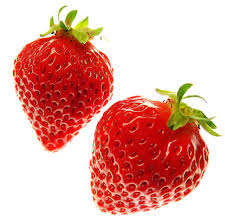

Imagen de Fresas
size =  (224, 225, 3)
max  =  255
min  =  0


In [60]:
# Lectura de la imagen
fresas_img = cv2.imread('fresas.jpg')

# Mostrar la imagen y sus dimensiones
mostrar_imagen_y_dimensiones(fresas_img, title="Imagen de Fresas")


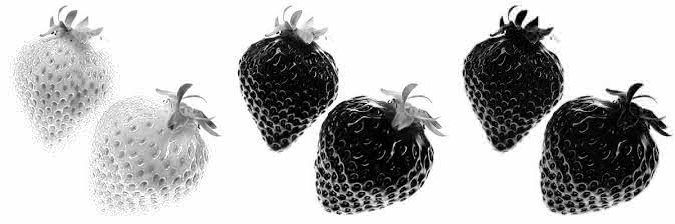

In [61]:
# Descomponer en canales RGB
R, G, B, img_rgb = descomponer_canales_rgb(fresas_img)
RGB = np.concatenate((R, G, B), axis=1)
cv2_imshow(RGB)


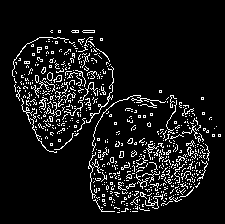

In [79]:
# Ajustar umbrales de segmentación
thresholds = {
    'R': 170,  # Umbral para el canal rojo
    'G': 190,   # Umbral para el canal verde
    'B': 150    # Umbral para el canal azul
}

# Segmentar las fresas
Q, img_rgb = segmentar_fresa(fresas_img, thresholds)

# Detectar bordes en las fresas segmentadas
bordes = detectar_bordes(Q)
cv2_imshow(bordes)

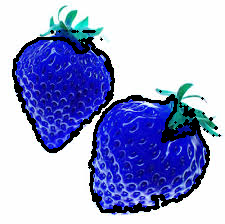

In [80]:
# Encontrar contornos de cada fresa segmentada
contornos = encontrar_contornos_segmentados(Q)

# Superposición de contornos en la imagen original
img_borders = img_rgb.copy()
cv2.drawContours(img_borders, contornos, -1, (0, 0, 0), 2)

cv2_imshow(img_borders)

Límites de la fresa segmentada: imin: 95, imax: 212, jmin: 89, jmax: 209


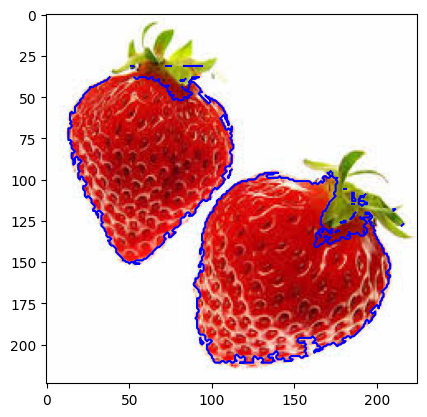

In [81]:
# Obtener y mostrar los límites del contorno más grande
if contornos:
    contorno_mayor = max(contornos, key=cv2.contourArea)
    limites = obtener_limites_contorno(contorno_mayor)
    print(f"Límites de la fresa segmentada: imin: {limites[1]}, imax: {limites[3]}, jmin: {limites[0]}, jmax: {limites[2]}")
else:
    print("No se encontraron contornos.")

# Mostrar los contornos de cada fresa
plt.imshow(img_rgb)
for contorno in contornos:
    contorno = contorno.squeeze()
    if contorno.ndim == 2 and contorno.shape[1] == 2:  # Verificar que el contorno es bidimensional
        plt.plot(contorno[:, 0], contorno[:, 1], 'b-')
plt.show()